# IN benchmark

In [1]:
%load_ext autoreload
%autoreload 2
from utils import get_opts
from launcher import launch_grid
from exps import *

## Train on IN benchmark

In [ ]:
opt = get_opts()
opt.delete_ckpt = False
opt.ngpus = 4
grid = {
    'steps':[None],
    'feat_arch':['ResNet50_224', 'ResNet34_224', 'ResNet18_224'],
    'seed':range(3),
}

jobs = launch_grid(exp_IN_base, opt, grid, folder=f'submitit_runs/0_eccv/IN_benchmark/0_IN/',
                   partition='uninterrupted')
# use 4 GPUs per experiment --> 11h

## Train on IN6k dataset

In [ ]:
opt = get_opts()
opt.delete_ckpt = False
opt.ngpus = 8 # do not remove this

grid = {
    'steps':[[50000, 80000, 100000]],#[None],
    'feat_arch':['ResNet34_224', 'ResNet50_224', 'ResNet18_224'],
    'seed':range(2),
}

jobs = launch_grid(exp_IN_IN6k, opt, grid, folder=f'submitit_runs/0_eccv/IN_benchmark/1_IN6k_short/',
                   partition='priority')

## Train on Rand classes - Trade-off 500k images

In [ ]:
opt = get_opts()
N = 50000

if N == 50000:
    opt.ngpus = 1 # for 50k
    name = '50k'
    ncs = [100, 250, 375]
elif N == 500000:
    opt.ngpus = 4 # for 500k
    name = '500k'
    ncs = [555, 1000, 2000, 2500, 5000]
else:
    raise ValueError('Check')
opt.delete_ckpt = False

grid = {
    'steps':[None],
    'feat_arch':['ResNet34_224'],
    'nc':ncs,
    'seed':range(3),
    'N':[N],
}

jobs = launch_grid(exp_IN_tradeoff, opt, grid, folder=f'submitit_runs/0_eccv/IN_benchmark/2_rand_IN6k_{name}/',
                   partition='uninterrupted')

## IN split 

In [ ]:
opt = get_opts()
opt.delete_ckpt = False
opt.ngpus = 4

grid = {
    'steps':[None], 
    'feat_arch':['ResNet34_224',],
    'seed':range(3),
    'nsplits':[1, 2, 4, 8],
}

jobs = launch_grid(exp_IN_split, opt, grid, folder=f'submitit_runs/0_eccv/IN_benchmark/3_IN_split/',
                   partition='uninterrupted')
# use 4 GPUs per experiment --> 11h

In [7]:
from plot_utils import *
# DONE - show_grid_and_results('submitit_runs/0_eccv/IN_benchmark/3_IN_split/', shot=1)
# show_grid_and_results('submitit_runs/0_eccv/miniIN6k_iSz_84_archs_bench/') # update results in the table
# show_grid_and_results('submitit_runs/0_eccv/IN_benchmark/1_IN6k/')
# show_grid_and_results('submitit_runs/2_eccv/feat_var_miniIN1k_baseline_384x100_64x600_val_cub//')
# show_grid_and_results('submitit_runs/0_eccv/split_miniIN6k_cub/')
# show_grid_and_results('submitit_runs/0_eccv/IN_benchmark/1_IN6k_short/')
# show_grid_and_results('submitit_runs/2_eccv/miniIN_cub_archs/', shot=1)
# show_grid_and_results('submitit_runs/2_eccv/trade_off_64x600_archs/', shot=1)
show_grid_and_results('submitit_runs/0_eccv/IN_benchmark/3_IN_split/', shot=5)
# evaluate submitit_runs/0_eccv/split_miniIN6k_cub/ models - 

{'seed': [0, 1, 2], 'nsplits': [2, 1, 8, 4]}
03  -  {'nsplits': 2} : 5-shot:79.23±0.15
03  -  {'nsplits': 1} : 5-shot:78.15±0.23
03  -  {'nsplits': 8} : 5-shot:80.35±0.09
03  -  {'nsplits': 4} : 5-shot:80.10±0.15


{'seed': [0, 1, 2], 'nsplits': [2, 1, 8, 4]}

In [74]:
# show_grid_and_results('submitit_runs/0_eccv/split_miniIN6k_cub/')
from plot_utils import *
# show_grid_and_results('submitit_runs/2_eccv/miniIN6k_iSz_84_archs_bench/')
result_dir = 'submitit_runs/2_eccv/miniIN6k_iSz_84_archs_bench/'
result_dir = 'submitit_runs/0_eccv/miniIN_cub/'
result_dir = 'submitit_runs/0_eccv/miniIN6k_iSz_84_archs_bench/'
result_dir = 'submitit_runs/2_eccv/closest_farthest_random_miniIN/'
result_dir = 'submitit_runs/2_eccv/feat_var_miniIN1k_baseline_384x100_64x600_val_cub/'
results, grid, arg = get_result_dict(result_dir, verbose=False, take={})#'feat_arch':'ResNet10'

10


# PLOT

In [1]:
from plot_utils import *
result_dir = 'submitit_runs/0_eccv/IN_benchmark/2_rand_IN6k_50k/'
results, grid, args = get_result_dict(result_dir)
grid

{'seed': [1, 0, 2], 'nc': [555, 1000, 2000, 2500, 5000, 100, 250, 375]}

15
23


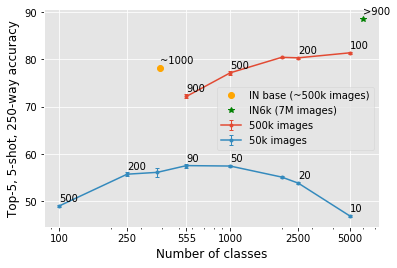

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

def fct(l,N):
    return [int(N//x) for x in l]

maxval = -1
for i, N in enumerate(['500k','50k']):
    result_dir = f'submitit_runs/0_eccv/IN_benchmark/2_rand_IN6k_{N}/'
    results, grid, args = get_result_dict(result_dir)
    take = {}
    results, grid, args = get_result_dict(result_dir, take=take)
    if not len(results):
        continue
    print(len(results))
    xaxis, top1ms, top1stds, top5ms, top5stds = get_kshot_mean_std('nc', grid, results)

    maxval = max(max(top5ms),maxval)

    (_, caps5, _) = ax.errorbar(xaxis, top5ms, top5stds, linestyle='-', marker='.', label=f'{N} images', capsize=2, 
                                elinewidth=1, color=colors[i])
    if N == '500k':
        xx = [555, 1000, 2500, 5000]
        txts = fct(xx, 500000)
        for i, xi in enumerate(xx):
            yi = top5ms[np.where(np.array(xaxis)==xi)[0][0]]
            ax.annotate(txts[i], (xi, yi+1))#top5ms[i]

    elif N == '50k':
        xx = [100, 250, 555, 1000, 2500, 5000]
        txts = fct(xx, 50000)
        for i, xi in enumerate(xx):
            yi = top5ms[np.where(np.array(xaxis)==xi)[0][0]]
            ax.annotate(txts[i], (xi, yi+1))#top5ms[i]
        
    
ax.set_xscale('log')
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
xaxis_labels = [100, 250, 555, 1000, 2500, 5000]

ax.set_xticks(xaxis_labels)
ax.set_xticklabels(xaxis_labels)
ax.set_xlabel(f'Number of classes')
ax.set_ylabel('Top-5, 5-shot, 250-way accuracy')

ax.plot([389],   [78.20], marker='o', linestyle='None',  label='IN base (~500k images)', color='orange')
ax.annotate('~1000', (389, 78.2+1))
ax.plot([6000],   [88.50], marker='*', linestyle='None',  label='IN6k (7M images)', color='green')
ax.annotate('>900', (6000, 88.50+1))
# ax.plot([2*389], [79.23], marker='d', linestyle='None',  label='IN base - split 2', color='orange')
# ax.plot([4*389], [80.10], marker='+', linestyle='None',  label='IN base - split 4', color='orange')
# ax.plot([8*389], [80.35], marker='x', linestyle='None',  label='IN base - split 8', color='orange')
ax.legend()

In [18]:
fig.savefig(f'submitit_runs/0_eccv/IN_benchmark/trade_off_50k_500k_IN.pdf', format='pdf', bbox_inches="tight")

In [17]:
from datasets import get_dataset
dset = get_dataset('miniIN6k')
np.mean([len(c) for c in dset.classes])

1189.186

In [ ]:
## Split miniIN6k - a then do trade-off figureb
# 6000*100 - 60000 - 
grid = {
    'N':[600000],
    'nc':[6000, 3000, 1500, 750],
    'seed':range(3),
}

# split miniIN6k into 8 then sample from 6000*8 --> TODO
grid = {
    'N':[600000],
    'nc':[12000, ]
}

In [ ]:
# 6000 classes x enough images so that when split stays > 100
# 6000x900 --> split --> 2,4,8

In [ ]:
# Split miniIN6k dataset and save it to json

In [ ]:
from utils import *
import torch
from datasets import classDataset
from exps import save_dataset_json
cluster_type = 'h_median_dich'
benchmark = 'cub'
feat = 'oracle'

# dset = sample_random_classes_images_miniIN6k(benchmark='benchmark')
# dset = get_dataset('IN')
# dset.transform = get_transform(ttype='miniIN', phase='test')

# features, targets = get_dataset_features(dset, feat=feat)

for nsplits in [2,4,8]:
    new_classes = []
    for i,c in enumerate(dset.classes):
        cind = c.initial_label
#         feats = get_miniIN6k_features_of_class(class_ind=cind, feat=feat)
        feats = features[targets==i]
        assert len(c) == feats.size(0)
        if cluster_type == 'kmeans':
            cluster_inds = kmeans_cluster(feats, nsplits, pcaDim=-1, verbose=False)
        elif cluster_type == 'h_median_dich':
            cluster_inds = hierarchical_splitting(feats, nsplits=nsplits, split_step=split_median)
        else:
            raise ValueError(f'Unrecognized Clustering type: {cluster_type}')

        for j in range(nsplits):
            inds = torch.where(cluster_inds==j)[0]
            new_class, _ = c.sample_n_images(inds=inds.tolist())
            new_classes.append(new_class)
        if i %100 == 0:
            print(i, len(new_classes))
    new_dset = classDataset(classes=new_classes)
    new_dset.parent_dset = dset
    new_dset.desc = f'Dataset created by splitting each dataset class into {nsplits}'
    # save dataset json
    save_dataset_json(new_dset, 'data/IN/split_IN/', filename=f'IN_split_{nsplits}_{cluster_type}_{feat}_{len(dset.classes)}.json')
    


In [44]:
f'IN_split_{nsplits}_{cluster_type}_{feat}_{len(dset.classes)}.json'

'IN_split_8_h_median_dich_oracle_389.json'

In [ ]:
# from plot_utils import show_grid_and_results
# show_grid_and_results('submitit_runs/0_eccv/miniIN6k_iSz_84_archs_bench/')